<a href="https://colab.research.google.com/github/egorssed/Lensed_Source_modelling_research/blob/main/Decoder_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/Lensed Source modelling research/'

import tensorflow as tf
device_name = tf.test.gpu_device_name()

import sys
sys.path.append(Folder+'/Modules')
import Image_Stats
import Visual_analysis

image_size=64
batch_size = 32
latent_dim = 64
start_lr = 1e-6

x = np.linspace(0, 64, 64)
y = np.linspace(0, 64, 64)
X, Y = np.meshgrid(x, y)
xdata = np.vstack((X.ravel(), Y.ravel()))

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split

#We normalize the data to [0,1]
#Initial minI and maxI are stored in the Dataset_labels
#All the negative values set to 0 during preprocessing
def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i]=images[i]/images[i].max()
    return images

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Images_Filtered_Rotated.npy')
df=pd.read_csv(Folder+'Data/Labels_Filtered.csv',index_col=0)

#Bring images to a proper tensorial form
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%batch_size)])
Number_of_batches=Size_of_dataset//batch_size
df=df.iloc[:Size_of_dataset]
galaxy_images=normalize_image(galaxy_images[:Size_of_dataset])

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(galaxy_images, (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))

#Separate the features we are eager to predict in the latent space
#Features=['Sersic_HLR', 'Sersic_n', 'Sersic_q','Sersic_phi']

#Extract test dataset
x_train, x_test ,y_train,y_test= train_test_split(gal_dataset_images.astype('float32'),df, test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train,y_train, test_size=round(0.05*Number_of_batches)*batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

# Neural Nets

## VAE


### libraries


In [3]:
import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization,Flatten,Reshape,Lambda,Conv2D,Conv2DTranspose,LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import initializers
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops,smart_cond
import keras.backend as K

### encoder

In [4]:
def encoder_function(input_img):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    
    #Predict mean of standard distribution and logarithm of variance
    Xavierinitializer=initializers.GlorotNormal()

    z_mean = Dense(latent_dim,kernel_initializer=initializers.Constant(value=0),bias_initializer=initializers.Constant(value=0))(x)
    z_log_var = Dense(latent_dim, kernel_initializer=initializers.Constant(value=0),bias_initializer=initializers.Constant(value=0))(x)

    return z_mean,z_log_var

### decoder

In [5]:
def get_decoder(activation):
  def decoder_function(z):
    #He initialization for Relu activated layers
    Heinitializer = initializers.HeNormal()

    x = Reshape(target_shape=(1, 1, 64))(z)
    
    x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same',use_bias=False,kernel_initializer=Heinitializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    #Xavier intialization for differentiable functions activated layers
    Xavierinitializer=initializers.GlorotNormal()
    if activation=='':
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False
                                ,kernel_initializer=Xavierinitializer)(x)
    else:
      decoded = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same',use_bias=False,
                              activation=activation,kernel_initializer=Xavierinitializer)(x)
  
    return decoded
  return decoder_function

### loss

In [6]:
def get_reconstruction_loss(loss_type='chi_sq'):

  #Chose original loss function
  if (loss_type=='chi_sq') or (loss_type=='mse'):
      loss_function=tf.math.squared_difference
  if loss_type=='binary_crossentropy':
      loss_function=K.binary_crossentropy

  def reconstruction_loss_function(y_true,y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    reconstruction_loss=loss_function(y_true,y_pred)

    #cast mse to chi_square by adding weights
    if (loss_type=='chi_sq'):
      #Poisson weights (sigma=sqrt(image))
      weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
      weights= math_ops.cast(weights, y_pred.dtype)
      reconstruction_loss=reconstruction_loss*weights
    
    return K.sum(reconstruction_loss,axis=-1)
  
  return reconstruction_loss_function

def get_regularization_loss(beta_vae=1e-3,gamma=None):
  #Capacity is a global variable that is changed during training
  def regularization_loss_function(mean,logvar):
    KL_loss=0.5 * K.sum(K.exp(logvar)+K.square(mean)-1-logvar, axis=-1)
    if (gamma is not None) and (Capacity is not None):  
      return gamma*tf.abs(KL_loss-Capacity)
    else:
      return beta_vae*KL_loss
  
  return regularization_loss_function

In [7]:
def get_model_loss(beta_vae=1e-3,loss_type='chi_sq',gamma=None):

  reconstruction_loss_function=get_reconstruction_loss(loss_type)
  regularization_loss_function=get_regularization_loss(beta_vae,gamma)

  def model_loss_function(x,decoded):

    #KL divergence regularization quality
    mean = models['z_meaner'](x)
    logvar=models['z_log_varer'](x)
    regularization_loss=regularization_loss_function(mean,logvar)

    #reconstruction quality
    flattened_x=K.reshape(x,shape=(len(x),image_size*image_size))
    flattened_decoded=K.reshape(decoded,shape=(len(decoded),image_size*image_size))
    reconstruction_loss=reconstruction_loss_function(flattened_x,flattened_decoded)

    Beta_VAE_Loss=(reconstruction_loss+regularization_loss)/image_size/image_size
    return Beta_VAE_Loss

  return model_loss_function,reconstruction_loss_function,regularization_loss_function

### vae class

In [8]:
def create_vae(beta_vae=1e-3,activation='softplus',loss_type='chi_sq',gamma=None):

    #Reparametrization trick
    def reparameterize(args):
      mean,logvar=args
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar/2) + mean
    decoder_function=get_decoder(activation)
    model_loss_function,reconstruction_loss_function,regularization_loss_function=get_model_loss(beta_vae,loss_type,gamma)


    #VAE
    models = {}

    #Encoder
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))

    z_mean, z_log_var=encoder_function(input_img)

    l=Lambda(reparameterize, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_log_varer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    #Decoder
    z = Input(shape=(latent_dim, ))
    decoded=decoder_function(z)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

In [9]:
def get_Neural_Network(beta_vae=1e-3,activation='softplus',loss_type='chi_sq',gamma=None):
  with tf.device('/device:GPU:0'):
    models,model_loss_function,reconstruction_loss_function,regularization_loss_function =create_vae(beta_vae,activation,loss_type,gamma)

    models["vae"].compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999,clipvalue=1), loss=model_loss_function)

    return models,model_loss_function,reconstruction_loss_function,regularization_loss_function

## Functions

In [462]:
from matplotlib import cm
import seaborn as sns

indices_to_compare=np.zeros(32,dtype=int)
indices_to_compare[:10]=[34,46,29,92,58,120,149,155,160,148]
imgs = x_test[indices_to_compare]
n_compare = 9

def plot_galaxies(*args,dimensions='2d',colorbar=False):
    #(num_of_rows,num_of_cols,im_shape[0],im_shape[1])
    args = [x.squeeze() for x in args]
    #num of cols
    n = min([x.shape[0] for x in args])
    I_max=np.max(args)
    print('Maximal brightness',I_max)

    if dimensions=='2d':
      fig=plt.figure(figsize=(2*n, 2*len(args)))
    else:
      fig=plt.figure(figsize=(5*n, 5*len(args)))

    for row in range(len(args)):
        for col in range(n):
            if dimensions=='2d':
                ax = fig.add_subplot(len(args),n,row*n+col+1)
                im=ax.imshow(args[row][col].squeeze(),cmap='Greys_r',vmax=I_max)
            else:
                ax = fig.add_subplot(len(args),n,row*n+col+1, projection='3d')
                ax.plot_surface(X, Y, args[row][col].squeeze(), cmap=cm.coolwarm,
                            linewidth=0, antialiased=False)
                ax.set_zlim(0,I_max)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0,hspace=0)
    #plt.show()

def present_reconstruction(models,imgs,dimensions='2d',resid=False):
    #Images selection
    images_for_reconst=imgs
    decoded_to_reconstruct=models['vae'].predict(images_for_reconst, batch_size=len(imgs))
    plot_galaxies(images_for_reconst[:10],decoded_to_reconstruct[:10],dimensions=dimensions)
    if resid:
      residuals=decoded_to_reconstruct-images_for_reconst
      plot_galaxies(residuals[:10],dimensions=dimensions,colorbar=True)

def latent_relation_of_variances(ratio,sorted=False):
    if sorted:
      g=sns.barplot(x=np.linspace(0,64,64),y=np.sort(ratio)[::-1])
    else:
      g=sns.barplot(x=np.linspace(0,64,64),y=ratio)
    #g.xaxis.set_visible(False)
    plt.hlines(1,0,63,label=r'$\mu_{std}=\sigma_{mean}$')
    plt.legend()
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('Ratio')
    plt.title(r'$\mu_{std}/\sigma_{mean}$')
    plt.show()

def DKL_per_variable(z_means,z_log_vars):
    DKL=-0.5 * K.mean(1 + z_log_vars - K.square(z_means) - K.exp(z_log_vars), axis=0)
    sns.barplot(x=np.linspace(0,64,64),y=np.sort(DKL)[::-1])
    plt.xticks([])
    plt.xlabel('Latent variable')
    plt.ylabel('nats')
    plt.title(r'KL_div')
    plt.show()
    return K.eval(DKL)

def galaxy_properties_from_latent_variables(models,z_means,number_of_z_to_consider=64,dimensions='2d',sort_array=None):
  latent_average=z_means.mean(axis=0)
  if sort_array is None:
    variables_to_consider=np.linspace(0,number_of_z_to_consider-1,number_of_z_to_consider,dtype=int)
  else:
    variables_to_consider=np.argsort(sort_array)[::-1][:number_of_z_to_consider]
  variances_to_consider=z_means.std(axis=0)[variables_to_consider]
  z_to_consider=np.zeros((number_of_z_to_consider,7,64))
  #i - number of variable to change
  for i in range(number_of_z_to_consider):
    #j - number of sigmas to add to it
    for j in range(7):
      #Assign everything to be like average galaxy
      z_to_consider[i,j,:]=latent_average
      #Vary one of the variables to get mu+-(0,1,2,3)*sigma
      z_to_consider[i,j,variables_to_consider[i]]+=(j-3)*variances_to_consider[i]
  images_to_consider=models['decoder'].predict(z_to_consider.reshape((number_of_z_to_consider*7,64)))
  #plot_digits(images_to_consider[:7],images_to_consider[7:14])
  for i in range(number_of_z_to_consider):
    plot_galaxies(images_to_consider[i*7:(i+1)*7],dimensions=dimensions)

def sample_random_images(models,z_means):
  sample_z=np.random.normal(z_means.mean(axis=0),z_means.std(axis=0),size=(32,64))
  sample_image=models['decoder'].predict(sample_z)
  plot_galaxies(sample_image[:10],sample_image[10:20],sample_image[20:30])

def latent_distribution(latent_variable):
  fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
  axs_flat = axs.flatten()  
  for i in range(latent_variable.shape[1]):
    axs_flat[i].hist(latent_variable[:,i], bins=50)
    axs_flat[i].set_title('Z {}'.format(i))
    axs_flat[i].get_yaxis().set_visible(False)
  fig.tight_layout()
  plt.show()


def chi_sq(image_true,image_pred):

    y_true=K.reshape(image_true,shape=(image_true.shape[0],image_size*image_size))
    y_pred=K.reshape(image_pred,shape=(image_pred.shape[0],image_size*image_size))
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    reconstruction_loss=tf.math.squared_difference(y_true,y_pred)

    weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
    weights= math_ops.cast(weights, y_pred.dtype)
    reconstruction_loss=reconstruction_loss*weights
    
    return K.eval(K.sum(reconstruction_loss,axis=-1))

import secrets
def disentanglement_score(models,z_means,number_of_z_to_consider=2):
  latent_average=z_means.mean(axis=0)
  latent_stds=z_means.std(axis=0)
  variables_to_consider=np.argsort(ratio)[::-1][:number_of_z_to_consider]
  n=2000
  disent_z=np.zeros((n,64))
  disent_index=np.zeros(n)
  for i in tqdm(range(n)):
    #Pick random index
    index=secrets.choice(variables_to_consider).astype(int)
    #Pick random value for it
    value=np.random.normal(latent_average[index],latent_stds[index])

    z1=np.random.normal(latent_average,latent_stds)
    z2=np.random.normal(latent_average,latent_stds)
  
    #Assign same value
    z1[index]=value
    z2[index]=value

    z1_sampled=models['z_meaner'](models['decoder'].predict(z1.reshape((1,64))))
    z2_sampled=models['z_meaner'](models['decoder'].predict(z2.reshape((1,64))))
    disent_z[i]=np.abs(z1_sampled-z2_sampled)/latent_stds
    disent_index[i]=index

  disent_z_train, disent_z_test ,disent_index_train,disent_index_test=train_test_split(disent_z,disent_index, test_size=0.2,random_state=42)
  disent_z_train, disent_z_val ,disent_index_train,disent_index_val=train_test_split(disent_z_train,disent_index_train, test_size=0.2,random_state=42)
  #disent_index_train=tf.keras.utils.to_categorical(disent_index_train, number_of_z_to_consider)
  #disent_index_val=tf.keras.utils.to_categorical(disent_index_val, number_of_z_to_consider)
  #disent_index_test=tf.keras.utils.to_categorical(disent_index_test, number_of_z_to_consider)

  classifier = tf.keras.Sequential(name="classifier")
  classifier.add(tf.keras.Input(shape=(64,)))
  classifier.add(tf.keras.layers.Dense(number_of_z_to_consider, activation="softmax"))
  with tf.device('/device:GPU:0'):
    classifier.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=1e-1), loss='sparse_categorical_crossentropy',metrics='accuracy')

  Stop_callback=tf.keras.callbacks.EarlyStopping(patience = 20)
  classifier.fit(disent_z_train,disent_index_train,batch_size=16,epochs=10000,callbacks=[Stop_callback],validation_data=(disent_z_val,disent_index_val),verbose=0)

  _,disentanglement_score=classifier.evaluate(disent_z_test,disent_index_test,batch_size=16)
  
  resampling_errors=pd.DataFrame(disent_z)
  resampling_errors['index']=disent_index

  return disentanglement_score,resampling_errors

def DKL_learning_curve(filename,start_epoch=0,stop_epoch=1000):
  text_file = open(filename, "r")
  lines = text_file.read().replace('\n','').replace('[','').split(']')
  nums=np.array([np.array([float(x) for x in line.split()]) for line in lines[:-1]])
  text_file.close()

  start_index=start_epoch//10
  stop_index=np.minimum(len(nums),stop_epoch//10-1)
  print(start_index,stop_index,len(nums))

  significant_vars=nums[-1].argsort()[-5:][::-1]
  for i in range(5):
    plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index,significant_vars[i]],label=i)
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL significant features Learning curve')
  plt.legend()
  plt.show()

  plt.plot(np.arange(start_index,stop_index),nums[start_index:stop_index].sum(axis=1))
  plt.ylabel('nats')
  plt.xlabel('Checkpoint number')
  plt.title('DKL Capacity Learning curve')
  plt.show()

def show_DKL(filename,epoch=10000):
  text_file = open(filename, "r")
  lines = text_file.read().replace('\n','').replace('[','').split(']')
  nums=np.array([np.array([float(x) for x in line.split()]) for line in lines[:-1]])
  text_file.close()
  epoch_index=np.maximum(epoch//10-1,0)
  index=np.minimum(len(nums)-1,epoch_index)

  significant_vars=nums[-1].argsort()[::-1]
  sns.barplot(x=np.linspace(0,64,64),y=nums[index][significant_vars])
  plt.xticks([])
  plt.xlabel('Latent variable')
  plt.ylabel('nats')
  plt.title(r'KL_div')
  plt.show()
  print(nums[index].sum())
  return K.eval(DKL)

## Fitting

In [493]:
from scipy.optimize import curve_fit,minimize
def calculate_chisq(latent_z,image):
    z=K.reshape(latent_z,shape=(1,64))
    image_pred=models['decoder'](z)
    y_true=K.reshape(image,shape=(1,64*64))
    y_pred=K.reshape(image_pred,shape=(1,64*64))
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    reconstruction_loss=tf.math.squared_difference(y_true,y_pred)

    weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
    weights= math_ops.cast(weights, y_pred.dtype)
    reconstruction_loss=reconstruction_loss*weights
    
    return K.eval(K.sum(reconstruction_loss,axis=-1))[0]


def calculate_gradient(latent_z,image):
    image_true=tf.constant(image.reshape((1,64,64,1)))
    z=tf.constant(K.reshape(latent_z,shape=(1,64)))
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as g:
      g.watch(z)
      image_pred=models['decoder'](z)

      y_true=K.reshape(image_true,shape=(1,64*64))
      y_pred=K.reshape(image_pred,shape=(1,64*64))
      
      #chi_squared
      reconstruction_loss=tf.math.squared_difference(y_true,y_pred)
      weights=tf.math.pow(tf.sqrt(tf.abs(y_true)+1e-5),-1)
      weights= math_ops.cast(weights, y_pred.dtype)
      reconstruction_loss=reconstruction_loss*weights
      chisq_loss=K.sum(reconstruction_loss,axis=-1)

    return K.eval(g.gradient(chisq_loss, z)[0])

def get_z_fit(index):
    image=imgs[index]
    z=latent_average.reshape((1,64))
    res=minimize(fun=calculate_chisq,x0=z,args=image,jac=calculate_gradient)
    return res

def compare_fits(index):

    #Decoder fit
    res=get_z_fit(index)
    #Vae reconstruction
    target_z=K.eval(models['z_meaner'](K.reshape(imgs[index,:,:,0],shape=(1,64,64,1)))[0])

    #Chameleon+Sersic
    fit_ChS,_=get_Chameleon_Sersic_fit(imgs[index,:,:,0])
    ChS_image=Image_Stats.Chameleon_Sersic(xdata,*fit_ChS).reshape(64,64)
    chi_squared_ChS=Image_Stats.chi_sq(imgs[index,:,:,0],ChS_image)

    return res.fun,calculate_chisq(target_z,imgs[index]),chi_squared_ChS,res.x,target_z,fit_ChS

In [441]:
!pip install lmfit

     |████████████████████████████████| 307kB 8.1MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 256kB 17.4MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=0224c87d8e0418b0e52ec618a039f787c33696414935af5f37066a0d73e2d239
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=68a9c6b3d42c30efdd8b41a093b1006f9be0d3dd2b473ddd7829e8e205a61804
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval


In [449]:
import lmfit
import tensorflow as tf
def fit_image_LMA(image,xdata,func,initial_guess,lower_bounds,upper_bounds):

    def residual(pars,xdata, data=None):
        fit=np.zeros(len(pars.items()))
        for i,item in enumerate(pars.items()):
            name,param=item
            fit[i]=param.value
        model=func(xdata,*fit)
        #Chi_sq
        return (model-data)/np.sqrt(np.abs(data)+image.max()*1e-5)

    fit_params = lmfit.Parameters()

    for i in range(len(initial_guess)):
        fit_params.add(name='par{}'.format(i),value=initial_guess[i], max=upper_bounds[i], min=lower_bounds[i])

    out = lmfit.minimize(residual, fit_params,args=(xdata,),
                   kws={'data': image.ravel()})

    fit=np.zeros(len(out.params.items()))
    errs=np.zeros(len(out.params.items()))
    for i,item in enumerate(out.params.items()):
        name,param=item
        fit[i]=param.value
        errs[i]=param.stderr

    return fit,errs

In [450]:
def get_Chameleon_Sersic_fit(image):
  func=Image_Stats.Chameleon_Sersic
  n_initial=1
  k=2*n_initial-0.324
  initial_guess=np.array([image.max()*20,2,0.1,0.88,0,
                             image.max()*np.exp(-k),10,n_initial,0.88,0,
                             image.shape[1]/2,image.shape[0]/2])
  lower_bounds=np.array([image.max()*1e-5,0,0,0.01,-np.pi/2,
                           0,0,0.5,0.01,-np.pi/2,
                           0,0])
  upper_bounds=np.array([np.inf,np.inf,1,1,np.pi/2,
                           image.max(),np.min(image.shape)/2,6,1,np.pi/2,
                           image.shape[1],image.shape[0]])
  
  return fit_image_LMA(image,xdata,func,initial_guess,lower_bounds,upper_bounds)

## Sigmoid BCE

In [12]:
beta_vae=1e-2
gamma=None
Start_Capacity=3
Capacity_speed=1
activation='sigmoid'
loss_type='binary_crossentropy'
models,model_loss_function,reconstruction_loss_function,regularization_loss_function=get_Neural_Network(beta_vae,activation,loss_type,gamma)


Checkpoint_to_load=320
Checkpoints_Folder=Folder+'Models/Sigmoid_BCE/'
models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

In [159]:
indices_to_compare=np.zeros(32,dtype=int)
indices_to_compare[:9]=[0,34,29,58,160,201,314,425,740]
imgs = x_test[indices_to_compare]

Maximal brightness 1.0


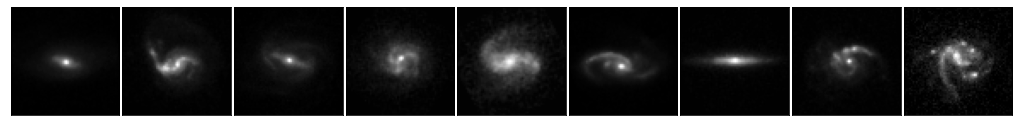

In [160]:
plot_galaxies(imgs[:9])

In [414]:
fit_columns=['chi_sq','z','encoded_z']
df_fit=pd.DataFrame(columns=fit_columns)
for index in range(9):
    results=compare_fits(index)
    df_fit=df_fit.append(pd.Series(results,index=fit_columns),ignore_index=True)

In [415]:
df_fit

,chi_sq,z,encoded_z
0,0.807404,"[1.4696507280389046, -0.8358131263726118, 0.92...","[0.7251126, -0.81140894, 1.2180644, 0.61423004..."
1,3.251763,"[0.5377526717303667, -2.592653393299734, 0.692...","[0.9130352, -1.790689, 0.18166895, 1.3580744, ..."
2,2.089568,"[0.9602184431826098, -0.7580779033869108, 0.39...","[0.7967458, -0.78774136, 1.0942494, 0.77181417..."
3,3.280487,"[0.9662468857411044, -0.588880467185856, 0.485...","[0.90400666, -0.2543685, 0.58783853, 1.522495,..."
4,5.620662,"[1.0658680247128731, -1.3720312316765073, 0.56...","[0.17952403, -1.2138752, 0.67357874, 1.1994331..."
5,1.856794,"[1.1376222789299646, 0.7753032553662342, 1.722...","[0.47426143, 1.2828317, 1.443564, 1.4499006, -..."
6,1.069026,"[1.3847349094627157, -1.8101104241607124, 0.91...","[1.0515969, -1.8411474, 0.90250057, 0.72543764..."
7,3.158635,"[0.8099238893474672, 0.20029235367881004, 1.01...","[-0.7053652, 0.14866485, 0.63968533, 1.2046959..."
8,20.793913,"[2.0299158208900057, 2.838718249161876, -3.033...","[0.8730224, 1.8219639, -0.9889964, 0.46260923,..."


Maximal brightness 1.0


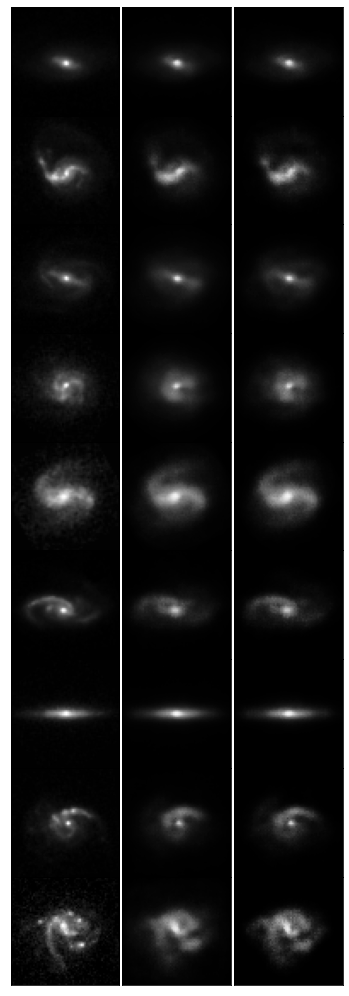

In [422]:
fit_images=np.zeros((len(df_fit),3,64,64,1))

z=np.concatenate(df_fit['z'],axis=0).reshape((len(df_fit),64))
encoded_z=np.concatenate(df_fit['encoded_z'],axis=0).reshape((len(df_fit),64))

images_true=imgs[:9,:,:,:]
images_fitted=models['decoder'](z)
images_vae=models['decoder'](encoded_z)

for i in range(len(df_fit)):
  fit_images[i]=[images_true[i],images_vae[i],images_fitted[i]]

plot_galaxies(*fit_images)

In [423]:
fit_errs=np.abs(z-encoded_z)/(np.ones((9,64))*z_means.std(axis=0))

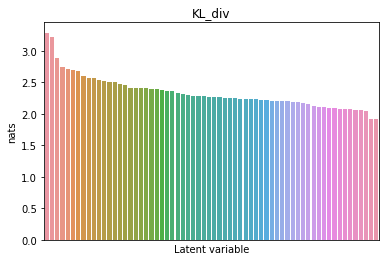

In [434]:
DKL=DKL_per_variable(z_means,z_log_vars)

variables_to_consider=np.argsort(DKL)[::-1]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


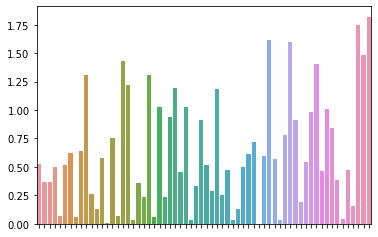

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


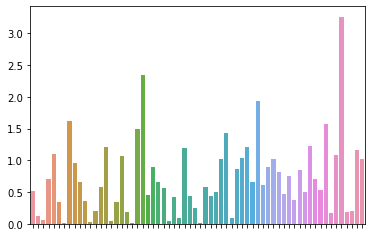

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


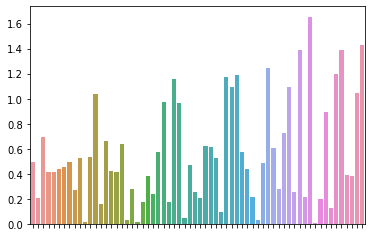

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


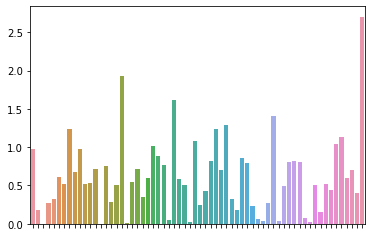

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


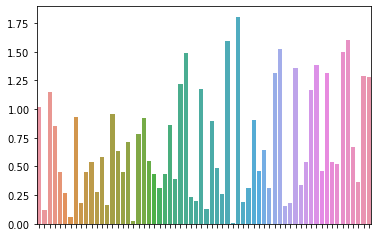

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


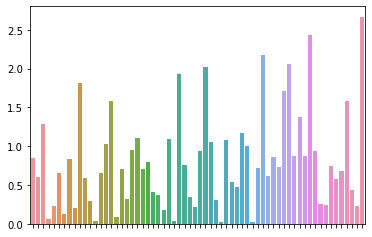

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


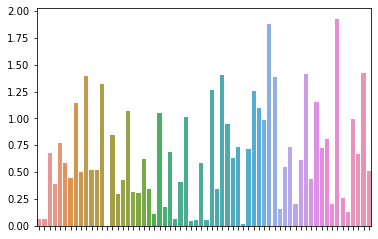

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


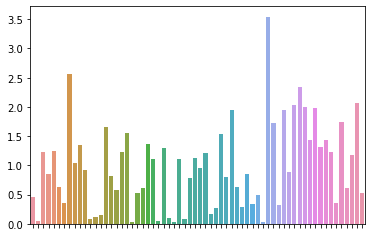

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


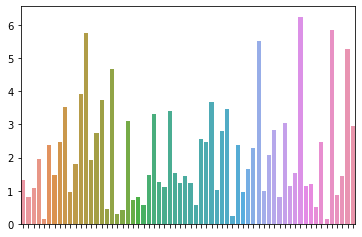

In [435]:
for i in range(9):
  g=sns.barplot(np.linspace(1,64,64),y=fit_errs[i][variables_to_consider])
  g.set_xticklabels([])
  plt.show()

## Softplus

### Chi_sq Poisson Beta=1e-3

In [439]:
beta_vae=1e-3
gamma=None
Start_Capacity=3
Capacity_speed=1
activation='softplus'
loss_type='chi_sq'
models,model_loss_function,reconstruction_loss_function,regularization_loss_function=get_Neural_Network(beta_vae,activation,loss_type,gamma)

Checkpoint_to_load=320
Checkpoints_Folder=Folder+'Models/Softplus_chisq_Poisson_beta=0.001/'
models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

In [491]:
fit_columns=['chi_sq_fit_decoder','chi_sq_vae','chi_sq_ChS','fit_z','encoded_z','ChS_fit']
df_fit=pd.DataFrame(columns=fit_columns)
for index in tqdm(range(9)):
    results=compare_fits(index)
    #df_fit=df_fit.append(pd.Series(results,index=fit_columns),ignore_index=True)




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:07<01:02,  7.86s/it]


 22%|██▏       | 2/9 [00:20<01:05,  9.37s/it]


 33%|███▎      | 3/9 [00:38<01:11, 11.87s/it]


 44%|████▍     | 4/9 [00:48<00:56, 11.33s/it]


 56%|█████▌    | 5/9 [00:56<00:41, 10.44s/it]


 67%|██████▋   | 6/9 [01:05<00:29,  9.90s/it]


 78%|███████▊  | 7/9 [01:17<00:20, 10.44s/it]


 89%|████████▉ | 8/9 [01:31<00:11, 11.67s/it]


100%|██████████| 9/9 [01:54<00:00, 12.73s/it]


Maximal brightness 1.0


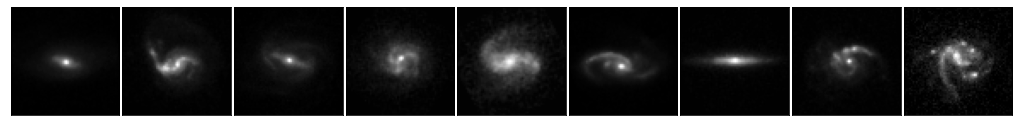

In [465]:
indices_to_compare=np.zeros(32,dtype=int)
indices_to_compare[:9]=[0,34,29,58,160,201,314,425,740]
imgs = x_test[indices_to_compare]
plot_galaxies(imgs[:9])

Maximal brightness 1.0025662183761597


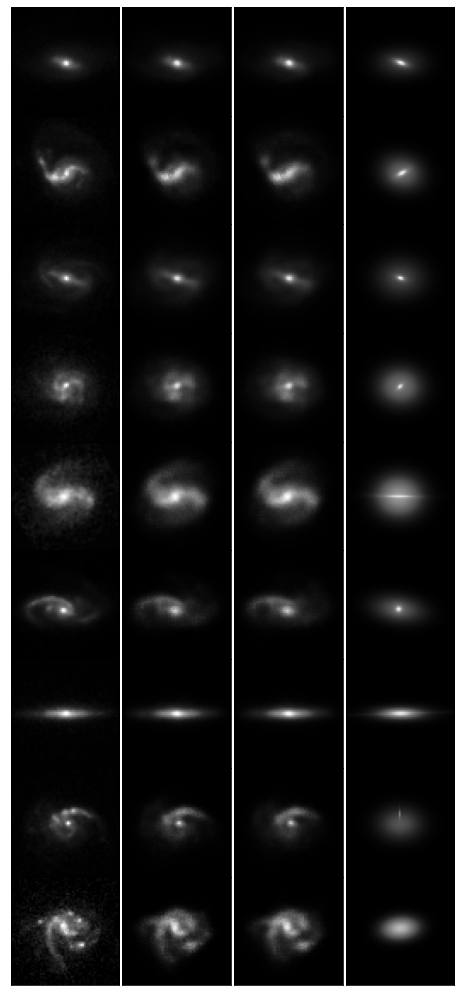

In [471]:
fit_images=np.zeros((len(df_fit),4,64,64,1))

z=np.concatenate(df_fit['fit_z'],axis=0).reshape((len(df_fit),64))
encoded_z=np.concatenate(df_fit['encoded_z'],axis=0).reshape((len(df_fit),64))
fit_ChS=np.concatenate(df_fit['ChS_fit'],axis=0).reshape((len(df_fit),len(df_fit.iloc[0].ChS_fit)))

images_true=imgs[:9,:,:,:]
images_fitted=models['decoder'](z)
images_vae=models['decoder'](encoded_z)

for i in range(len(df_fit)):
  image_ChS=Image_Stats.Chameleon_Sersic(xdata,*fit_ChS[i]).reshape((64,64,1))
  fit_images[i]=[images_true[i],images_fitted[i],images_vae[i],image_ChS]

plot_galaxies(*fit_images)
plt.savefig(Folder+'chisq_fitting')

In [467]:
df_fit

,chi_sq_fit_decoder,chi_sq_vae,chi_sq_ChS,fit_z,encoded_z,ChS_fit
0,0.614468,0.735862,18.517048,"[-0.0004942244622140003, 1.445360158775815, -0...","[-0.08408594, 1.6116667, -0.85081244, 0.542589...","[22.205792726713973, 2.2464386535214644, 0.851..."
1,3.152018,3.776615,56.412349,"[-0.654243816457054, 3.7744367636254994, 0.557...","[-0.5885795, 4.112729, 0.4676064, 2.075056, -1...","[24.434992606570837, 2.170748027074864, 0.8933..."
2,1.934141,2.136104,35.044457,"[-0.8786104140614556, 1.6110516340763863, -0.5...","[-1.1110734, 1.6785264, -0.50623536, 0.8658442...","[19.216018292381396, 1.4361779912583525, 0.879..."
3,2.989583,3.212350,32.221541,"[-0.6298772583433739, 2.226303900214363, -1.34...","[-0.6242044, 2.2455099, -1.5451201, 1.2502731,...","[13.751484110376449, 1.3123651834407077, 0.894..."
4,5.354225,5.717241,71.630165,"[-0.5238014880288596, 1.848883441918388, 0.307...","[-0.6605841, 2.046039, 0.3811359, 2.8395474, -...","[35.03854170386829, 5.061153053886172, 0.92059..."
5,1.763952,2.338906,30.507276,"[-0.6560524514658294, 1.814857491847416, -0.76...","[-0.16608676, 2.1194167, -1.1963016, 0.3356225...","[14.528256750843067, 1.7856188482949982, 0.858..."
6,1.023711,1.106685,13.746631,"[0.6385304884929877, 1.457700931004877, -1.822...","[0.72417367, 1.5669514, -1.527636, 2.057613, -...","[99.27845529720435, 15.357976936173191, 0.9775..."
7,2.826879,3.443155,37.244412,"[-1.0621322283848067, 2.6600912532679892, -0.2...","[-1.4706404, 2.2247741, -0.6554567, 1.497991, ...","[22.15222006903058, 1.2990369348091142, 0.2746..."
8,19.757286,21.295307,156.000214,"[-2.4406992926606894, 1.1590549113593458, -2.7...","[-2.4419343, 1.4436595, -1.6567398, 1.6195439,...","[0.7967424334150351, 4.066972349104985, 0.9999..."


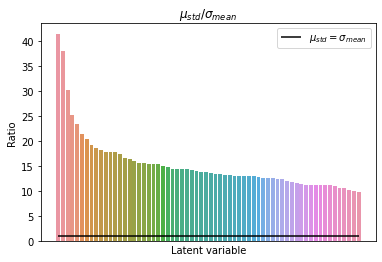

In [475]:
latent_relation_of_variances(ratio,sorted=True)

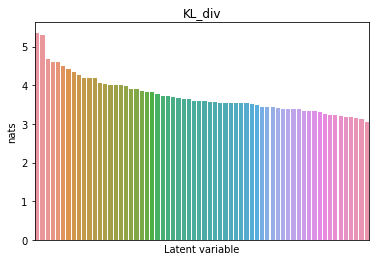

In [472]:
DKL=DKL_per_variable(z_means,z_log_vars)

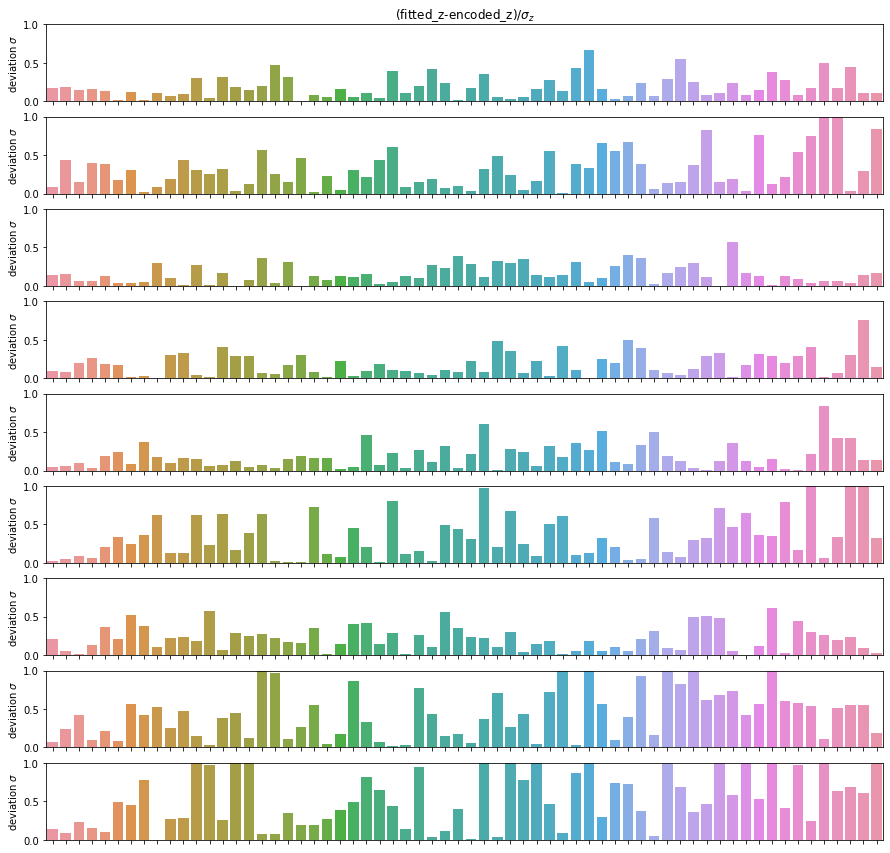

In [489]:
fit_errs=np.abs(z-encoded_z)/(np.ones((9,64))*z_means.std(axis=0))
variables_to_consider=np.argsort(ratio)[::-1]
fig,ax=plt.subplots(9,figsize=(15,15))
for i in range(9):
  g=sns.barplot(ax=ax[i],x=np.linspace(1,64,64),y=fit_errs[i][variables_to_consider])
  g.set_ylim(0,1)
  g.set_ylabel('deviation '+r'$\sigma$')
  if i==0:
    g.set_title(r'(fitted_z-encoded_z)/$\sigma_z$')
  g.set_xticklabels([])

#plt.savefig(Folder+'chisq_latent_err_SNR_sorted')

Maximal brightness 1.0


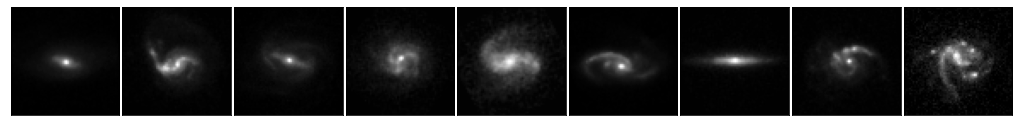

In [494]:
plot_galaxies(imgs[:9])

In [497]:
#np.save(Folder+'benchmark_images.npy',imgs[:9])